### 1. Preliminaries

In [1]:
import utils as ut
import plot_utils as put

import os
import glob
import pickle
import xarray as xr
import numpy as np
import pandas as pd
from itertools import combinations, product
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
ENERGY_PATH = '/net/pc200256//nobackup/users/most/output/LENTIS_2023_PD/agg_production/per_country/'
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
WINDOW = 7
NUM_EVENTS = 1600
VARIABLE = 'demand' # option 2: total_RE
RUNNAME = 'LENTIS_2023_PD'
CLUSTER_REMAPPING = {0: int(2), 1: int(0), 2: int(1), 3: int(3), 4: int(4)} # make sure to change after new clustering run! remap the clusters to the correct order; so that names are as below, 
CLUSTER_NAMES = {0: 'NAO -', 1: 'NAO +', 2: 'Blocking', 3: 'Atl. Ridge'} 

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/concurrent_probs_{WINDOW}d/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/concurrent_probs_{WINDOW}d/'

In [3]:
PATH_ED = '../../energydroughts-Europe/data/'
ed = pd.read_csv(os.path.join(PATH_ED, f'netto_demand_el7_winter_LENTIS_2023_PD_{NUM_EVENTS}_events.csv')).reset_index(drop=True)
ed['run'] = ed['runs'].str.extract('(\d+)').astype(int)
df_events = ed.drop(['Unnamed: 0', 'runs'], axis = 1)

In [4]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)

data = ut.load_data(ENERGY_PATH, VARIABLE, RUNNAME, stacked = False)

cluster_path = "../Results/clusters_Bayes_full_v1/clusters_full.csv"
df_wr = pd.read_csv(cluster_path)

df_wr = df_wr[['time', 'run', 'cluster_id', 'Bayes_cluster']]
df_wr['Bayes_cluster'] = df_wr['Bayes_cluster'].map(CLUSTER_REMAPPING)
df_wr['cluster_id'] = df_wr['cluster_id'].map(CLUSTER_REMAPPING)

df_wr['time'] = pd.to_datetime(df_wr['time'])
df_wr['time'] = df_wr['time'].apply(lambda dt: dt.replace(hour=12, minute=0, second=0)) # set time to noon, to match df. Is daily average anyway

# COUNTRY_NR = data.country.values
# COUNTRY_NAME = data.country_name.values
# country_nr_name = dict(zip(COUNTRY_NR, COUNTRY_NAME))
# country_name_nr  = dict(zip(COUNTRY_NAME, COUNTRY_NR))

HOMEDIR = '/usr/people/duinen/MSc-thesis/'
ROW_ORDER = np.load(f'{HOMEDIR}Data/row_order_nettodemand_v20240220.npy') # load the row ordering of the clustered residual heatmap, to follow the same clustering!
CMAP = 'RdBu_r'

Creating dir ../Results/Data/20240223/demand/concurrent_probs_7d/
Creating dir ../Results/Figures/20240223/demand/concurrent_probs_7d/


In [5]:
COUNTRY_NAME = ['AUT', 'BEL', 'CHE', 'CZE', 'DEU', 'DNK',
             'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'HRV', 'HUN', 'IRL',
             'ITA', 'LTU', 'LVA', 'NLD', 'NOR', 'POL', 'PRT',
             'SVK', 'SVN', 'SWE']

In [6]:
df_events.query('country.isin(@COUNTRY_NAME)', inplace = True) # just for now

### 2. Define functions

In [7]:
def find_dominant_wr(df_events, df_wr, cluster_col):
    df_events['weather_regime_ids'] = None
    df_events['dominant_weather_regime'] = None

    # Iterate over the rows of overlapping_events_df
    for index, row in df_events.iterrows():
        run_condition = (df_wr['run'] == row['run'])
        date_condition = (df_wr['time'] >= row['start_time']) & (df_wr['time'] <= row['end_time'])
        
        # Filter df_wr based on run and date conditions
        relevant_weather_regimes = df_wr[run_condition & date_condition][cluster_col].tolist()
        
        dominant_2 = Counter(relevant_weather_regimes).most_common(2)

        #TODO: Maybe set as threshold, dominant regime has to occur at least 50% of the days, so 4 out of 7 days. Otherwise set to 5, no persisting regime, and discard
        if len(dominant_2) == 1:
            df_events.at[index, 'dominant_weather_regime'] = dominant_2[0][0]
        elif len(dominant_2) > 1:
            if dominant_2[0][1] - dominant_2[1][1] > 1: # if one regime occurs at least two days more
                df_events.at[index, 'dominant_weather_regime'] = dominant_2[0][0]
            elif dominant_2[0][1] - dominant_2[1][1] <= 1:
                df_events.at[index, 'dominant_weather_regime'] = 5 # no persisting regime #[dominant_2[0][0], dominant_2[1][0]]
        # Update the 'weather_regime_ids' column in overlapping_events_df
        df_events.at[index, 'weather_regime_ids'] = relevant_weather_regimes
    return df_events

In [8]:
def get_co_occurrence(df_full, wr):
    overlapping_events_list = []
    co_occur_prob_list = []

    if wr != 'all':
        df = df_full.query('dominant_weather_regime == @wr')
        num_events_for_wr = df_events.query('dominant_weather_regime == @wr').groupby('country').size()
    if wr == 'all':
        num_events_for_wr = df_events.groupby('country').size()
        df = df_full.copy()

    grouped_runs = df.groupby('run')
    # grouped_runs_country2 = df_full.groupby('run')
    
    for run, run_group in tqdm(grouped_runs):
        # country_combinations = product(run_group['country'].unique(), repeat=2)
        country_combinations = product(df_full['country'].unique(), repeat=2)
        for country_1, country_2 in country_combinations:
            co_occur = 0 # reset counter
            events_country_1 = run_group[run_group['country'] == country_1].sort_values(by='start_time')
            events_country_2 = df_full.query('run == @run & country == @country_2').sort_values(by='start_time')


            # Iterate over rows of both DataFrames to check for overlapping events
            for _, event_country_1 in events_country_1.iterrows():
                for _, event_country_2 in events_country_2.iterrows():

                    if event_country_1['end_time'] >= event_country_2['start_time'] and \
                       event_country_2['end_time'] >= event_country_1['start_time']:
                        co_occur += 1

                        overlapping_events_list.append({
                            'country_1': country_1,
                            'event_number_1': event_country_1['event_number'],
                            'start_time_1': event_country_1['start_time'],
                            'end_time_1': event_country_1['end_time'],
                            'country_2': country_2,
                            'event_number_2': event_country_2['event_number'],
                            'start_time_2': event_country_2['start_time'],
                            'end_time_2': event_country_2['end_time'],
                            'run': run
                        })

            co_occur_prob_list.append({
                'country_1': country_1,
                'country_2': country_2,
                'run': run,
                'count': co_occur
            })

    overlapping_events_df = pd.DataFrame(overlapping_events_list)
    co_occur_prob_df = pd.DataFrame(co_occur_prob_list)

    co_occur_prob_df = co_occur_prob_df.groupby(['country_1', 'country_2'], as_index=False)['count'].sum()
    co_occur_prob_df['prob'] = co_occur_prob_df.groupby('country_1')['count'].transform(lambda x: x / num_events_for_wr[x.name])
    return overlapping_events_df, co_occur_prob_df, num_events_for_wr

In [9]:
def reorder(matrix):
    df_matrix = pd.DataFrame(matrix)

    matrix_reordered = df_matrix.reindex(ROW_ORDER, axis=0)
    matrix_reordered = matrix_reordered.reindex(ROW_ORDER, axis=1)
    return matrix_reordered.values

In [20]:
def plot_heatmap_reindexed(prob_df, reference, title):

    prob_df['country_1_index'] = prob_df['country_1']
    prob_df['country_2_index'] = prob_df['country_2']

    prob_df['prob'] = pd.to_numeric(prob_df['prob'])

    heatmap_data = prob_df.pivot(index = ['country_1_index'], columns = ['country_2_index'], values = 'prob')
    
    num_rows = 1
    num_cols = 2

    aspect_ratio = 1.0

    fig_width = 17
    fig_height = fig_width / (num_cols * aspect_ratio) * num_rows

    plt.figure(figsize=(fig_width, fig_height))

    # First subplot (Co-occurrence)
    plt.subplot(num_rows, num_cols, 1, aspect=aspect_ratio)
    plt.title(f'Co-occurrence of extreme 7d events for {title}')
    hm = sns.heatmap(reorder(heatmap_data.values), cmap='Reds',
                    xticklabels=np.array(COUNTRY_NAME)[ROW_ORDER], 
                    yticklabels=np.array(COUNTRY_NAME)[ROW_ORDER],
                    cbar_kws={'location':'right', 'use_gridspec':False, 'shrink': 0.75})


    # Second subplot (Co-occurrence anomalies)
    plt.subplot(num_rows, num_cols, 2, aspect=aspect_ratio)
    plt.title(f'Co-occurrence anomalies of extreme 7d events for: {title}')
    hm = sns.heatmap(reorder(heatmap_data.values) - reference, cmap=CMAP,  
                    vmin=-0.3, vmax=0.3,
                    xticklabels=np.array(COUNTRY_NAME)[ROW_ORDER], 
                    yticklabels=np.array(COUNTRY_NAME)[ROW_ORDER],
                    cbar_kws={'location':'right', 'use_gridspec':False, 'extend': 'both', 'shrink': 0.75})
    plt.show()
    return reorder(heatmap_data.values)

### 3. Perform co-occurrence analysis

In [11]:
df = find_dominant_wr(df_events, df_wr, cluster_col = 'Bayes_cluster')

In [12]:
events_df, prob_df, num_events_per_wr = get_co_occurrence(df_full = df_events, wr = 'all')

  0%|          | 0/160 [00:00<?, ?it/s]

<Figure size 1000x800 with 0 Axes>

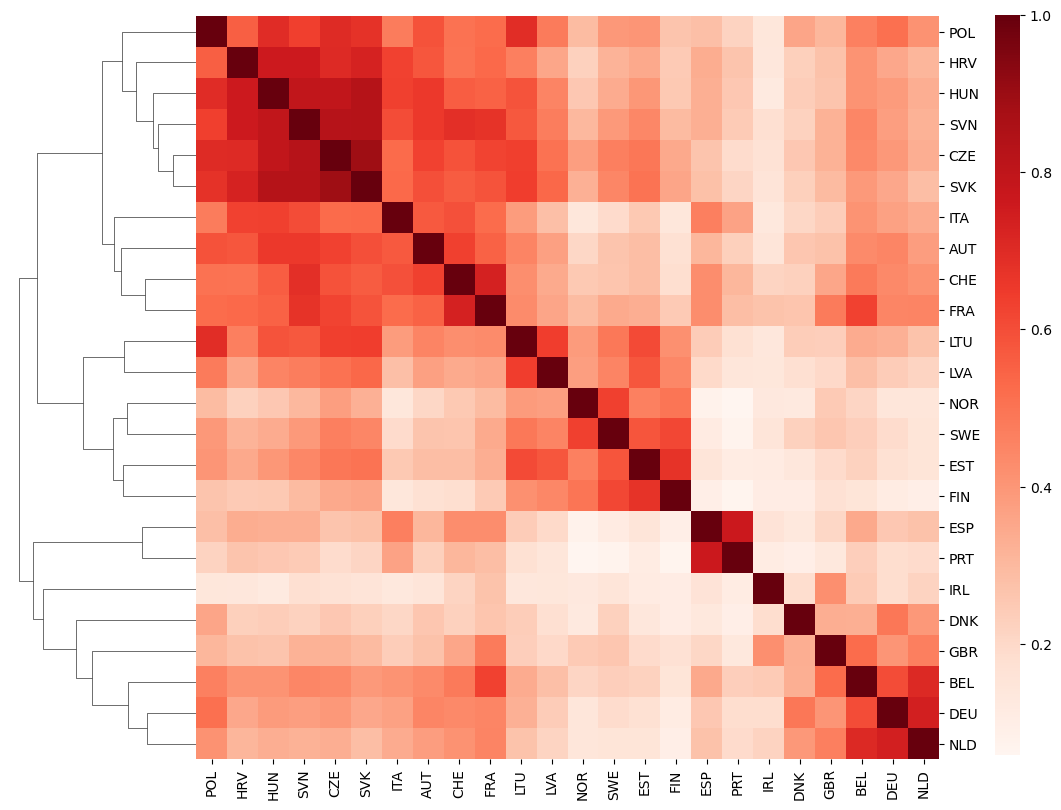

In [13]:
prob_df['country_1_index'] = prob_df['country_1']
prob_df['country_2_index'] = prob_df['country_2']

prob_df['prob'] = pd.to_numeric(prob_df['prob'])

heatmap_data = prob_df.pivot(index = ['country_1_index'], columns = ['country_2_index'], values = 'prob')

plt.figure(figsize=(10, 8))
cg = sns.clustermap(heatmap_data.values, cmap='Reds', xticklabels=COUNTRY_NAME, yticklabels=COUNTRY_NAME)
cg.ax_col_dendrogram.set_visible(False)
x0, _y0, _w, _h = cg.cbar_pos
cg.ax_cbar.set_position([1, 0.06, 0.025, 0.74])
row_order = cg.dendrogram_row.reordered_ind
# dendrogram_lines = cg.ax_row_dendrogram.get_lines()
# np.save(f'../Data/row_order_nettodemand_v{rundate}.npy', row_order) 

In [14]:
prob_df.to_csv(f'{dir_Output}_alldata.csv', index = False)

In [15]:
alldata_df = pd.read_csv(f'{dir_Output}_alldata.csv')

In [16]:
co_occurrence_all = reorder(heatmap_data.values)

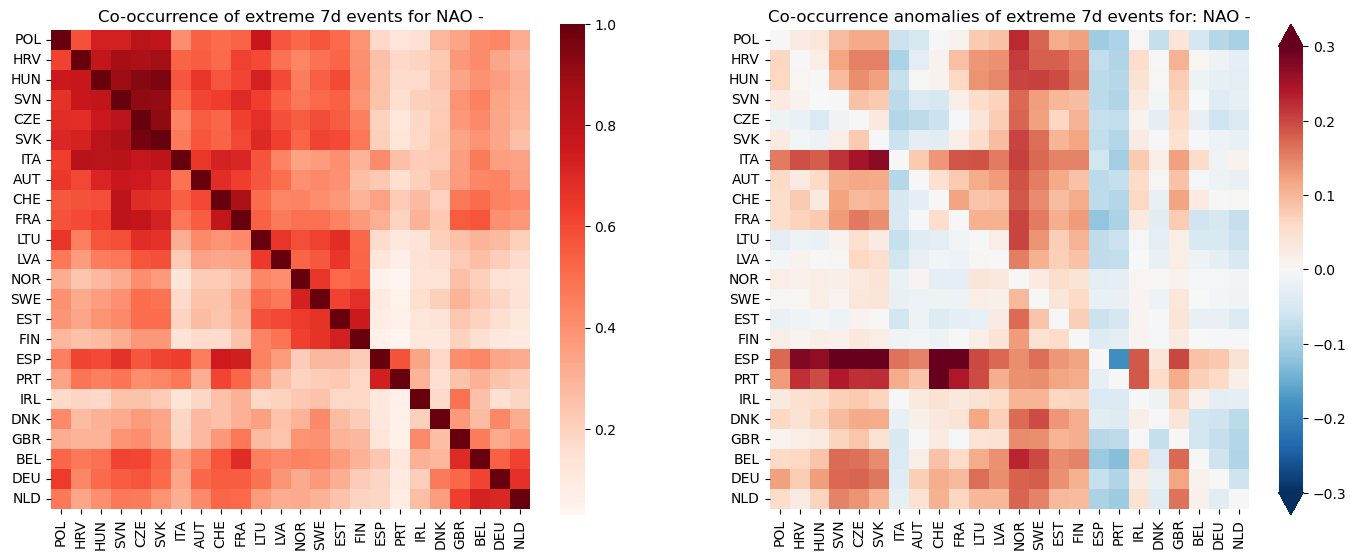

  0%|          | 0/159 [00:00<?, ?it/s]

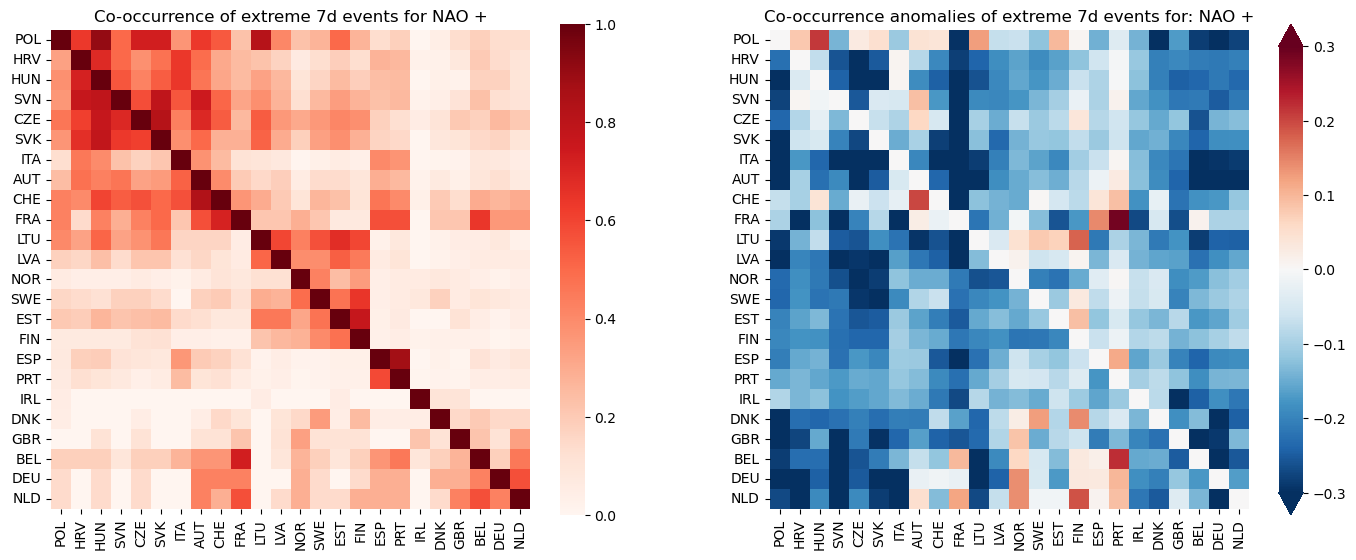

  0%|          | 0/160 [00:00<?, ?it/s]

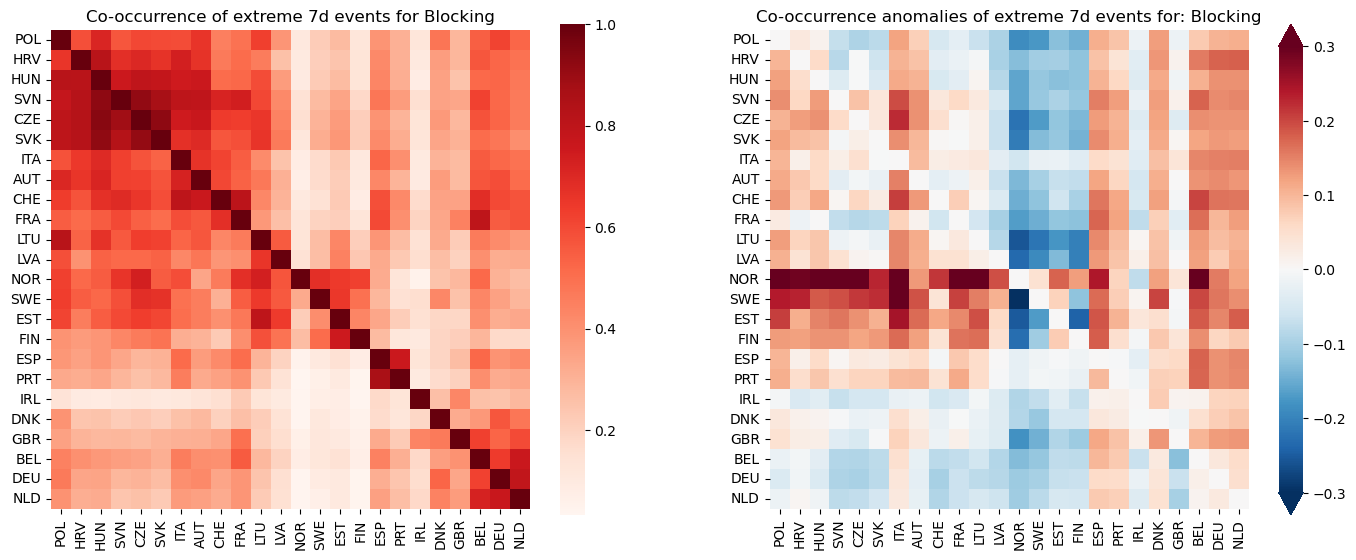

  0%|          | 0/160 [00:00<?, ?it/s]

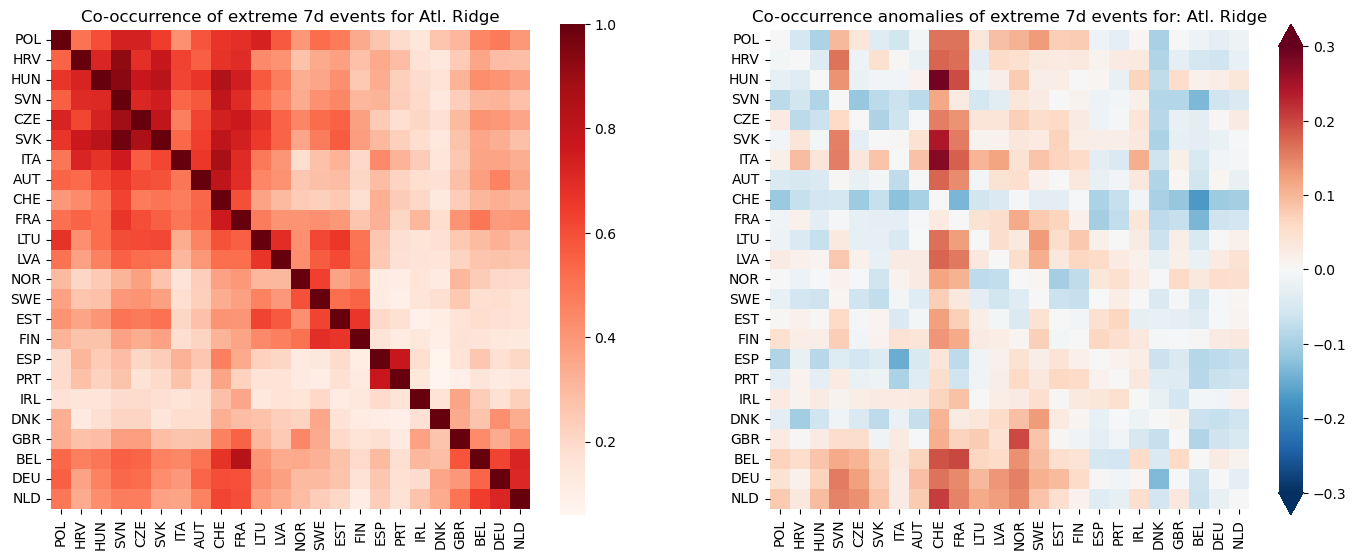

  0%|          | 0/149 [00:00<?, ?it/s]

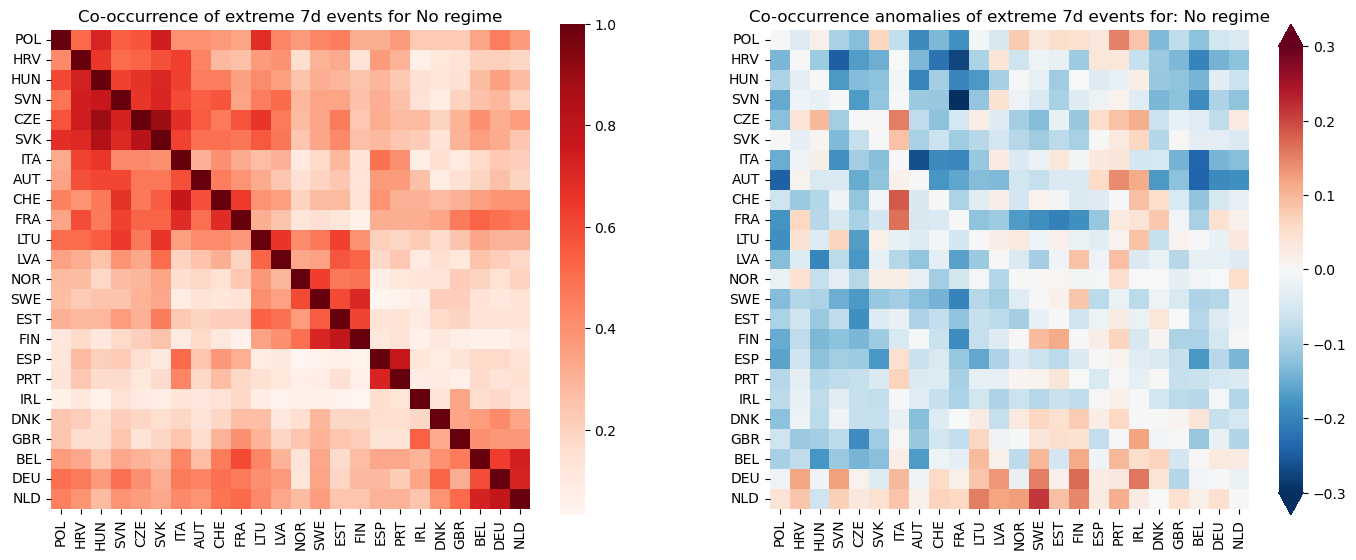

  0%|          | 0/160 [00:00<?, ?it/s]

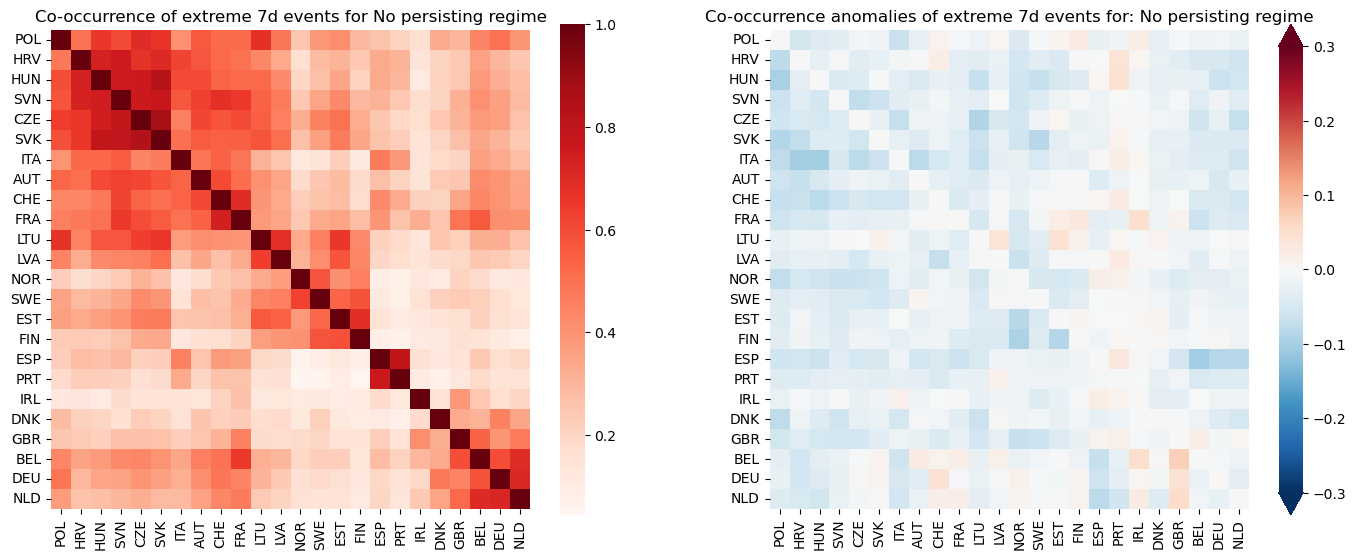

  0%|          | 0/160 [00:00<?, ?it/s]

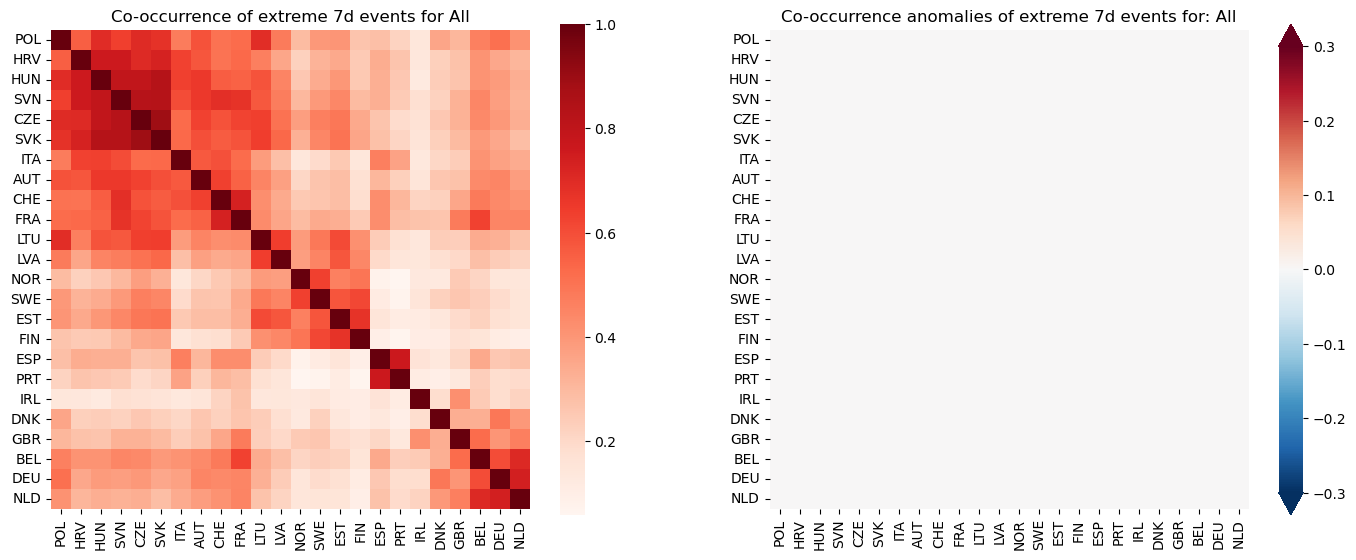

In [21]:
wrs = [0, 1, 2, 3, 4, 5, 'all']
titles = ['NAO -', 'NAO +', 'Blocking', 'Atl. Ridge', 'No regime', 'No persisting regime', 'All']

co_occurrence_dict = {}

for i, wr in enumerate(wrs):
    if i != 0: # temporary
        events_df, prob_df, num_events_per_wr = get_co_occurrence(df_full=df_events, wr=wr)

    probs_regime = plot_heatmap_reindexed(prob_df, co_occurrence_all, titles[i])

    co_occurrence_dict[titles[i]] = {
        'events_df': events_df,
        'prob_df': prob_df,
        'probs_regime': probs_regime,
        'anomalies_regime': probs_regime - co_occurrence_all
    }

with open(f'co_occurrence_dict_v{rundate}.pickle', 'wb') as f:
    pickle.dump(co_occurrence_dict, f)

In [ ]:
# co_occurrence_dict = pickle.load(open('co_occurrence_dict_v20240222.pickle', 'rb'))

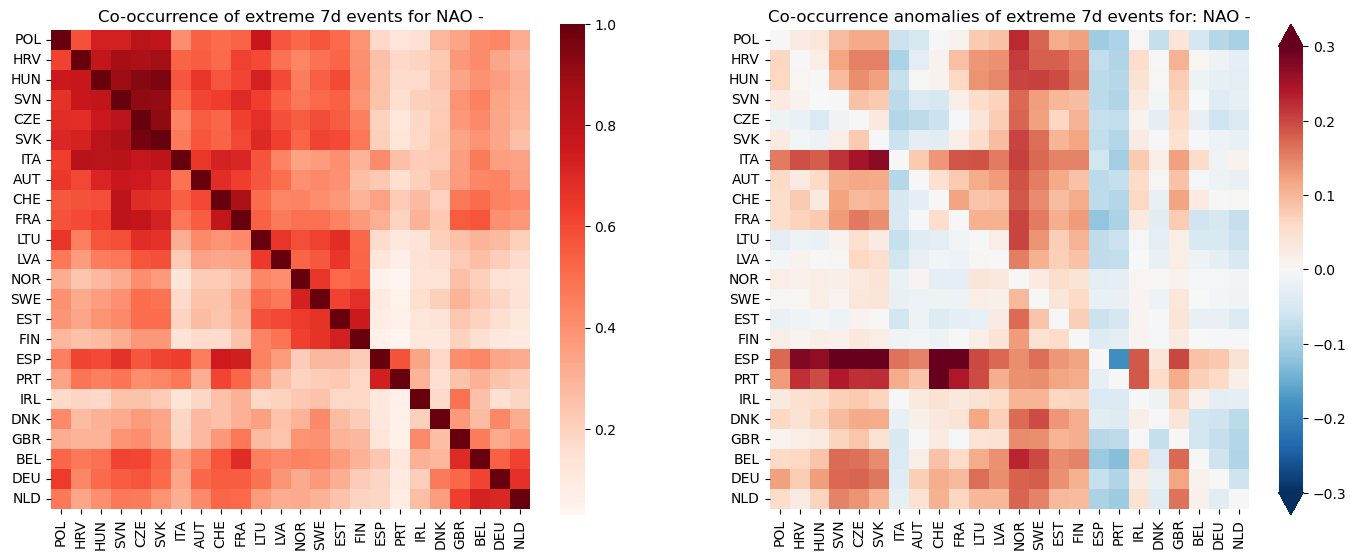

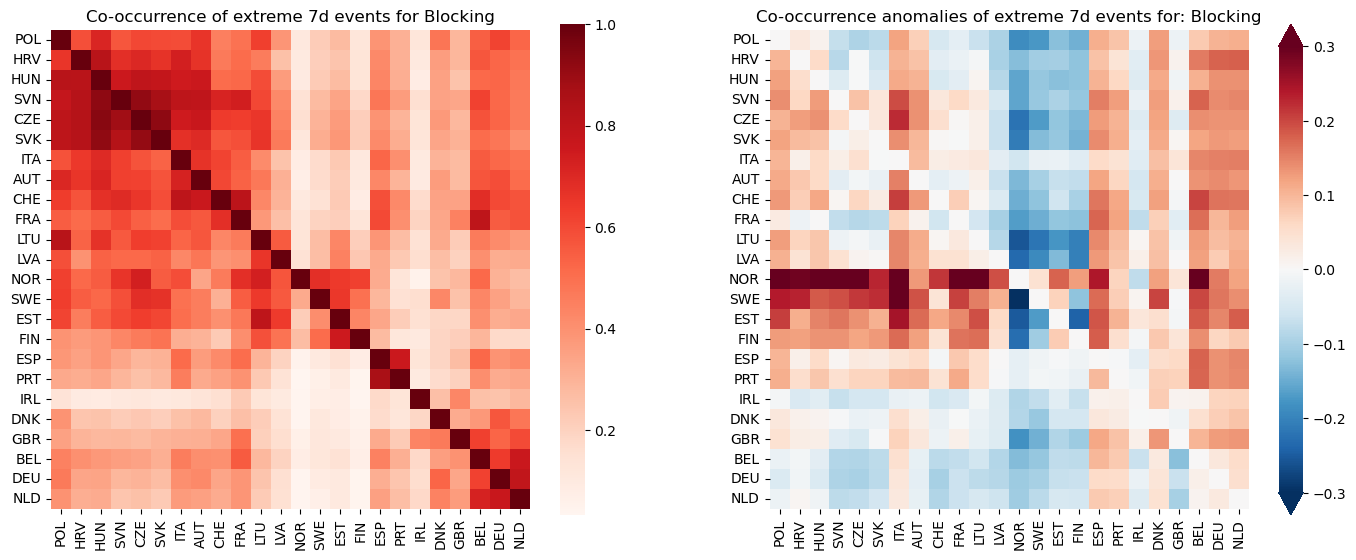

In [ ]:
wrs = [0, 2]
titles = ['NAO -', 'Blocking']

for i, wr in enumerate(wrs):
    prob_df = co_occurrence_dict[titles[i]]['prob_df']    
    probs_regime = plot_heatmap_reindexed(prob_df, co_occurrence_all, titles[i])